# Facial Keypoint Detection
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection and using computer vision techniques to transform images of faces.  The first step in any challenge like this will be to load and visualize the data you'll be working with. 

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='images/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## Load and Visualize Data

The first step in working with any dataset is to become familiar with your data; you'll need to load in the images of faces and their keypoints and visualize them! This set of image data has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

#### Training and Testing Data

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for you to use as you create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

---

Image name: Albert_Brooks_12.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 67. 134.]
 [ 69. 144.]
 [ 72. 154.]
 [ 77. 165.]]


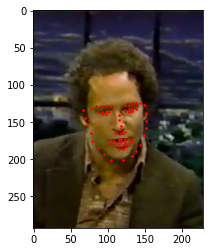

FileNotFoundError: No such file: '/Users/jsingh6/Documents/GitHub/P1_Facial_Keypoints/data/Luis_Fonsi_21.jpg'

In [3]:
# Import necessary packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from skimage import io

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform as sk_transform
from skimage import util

import cv2

import torch
from torchvision import transforms, utils

# Load and visualize data
landmarks_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 5
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('data/training/', img_name)),
               landmarks)
plt.show()



class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample



class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""  
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = util.img_as_ubyte(image)
        image_copy = np.copy(image)
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
        image_copy = image_copy / 255.0
        return {'image': image_copy, 'landmarks': landmarks}

class Rescale(object):
    """Rescale the image in a sample to a given size."""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = sk_transform.resize(image, (new_h, new_w))
        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """Crop randomly the image in a sample."""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,
                      left: left + new_w]
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        if(len(image.shape) == 2):
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

# Define the transforms
data_transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

# Test out the transforms
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

# Create the transformed dataset
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break